In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
import math
import seaborn as sns

In [53]:
%matplotlib inline

In [ ]:
#Comments and vars in polish, because no one outside this coutry will ever use it.
#Starting this year, we have new tax law in Poland, this is a notebook to calculate the best tax option to choose, to be most profitable, but still less than before this tax revolution


In [3]:
df = pd.DataFrame()


#******************************
#=== PARAMETRY DO OBLICZEN ===
#******************************
# ??? Kalkualtor nie uwzglednia podatku VAT


czy_spoleczna = 0 #1 jesli placisz skladkę społeczną, 0 jesli to jest dodatkowa działalność do UoP i płacisz tylko zdrowotną
skladka_spoleczna = 3553.20

dodatkowo_UoP = 1 #1 jesli oprocz dzialalnosci masz UoP, 0 jesli tylko dzialalnosc
zarobki_UoP = 6666 #zarobki na UoP

#Parametry do oblicznia DataFrame

brutto_miesiecznie_min = 2000 #Zakres dochodu dla ktorego ma byc przeprowadzona symulacja
brutto_miesiecznie_max = 20000
brutto_miesiecznie_step = 2000

#Czy koszty sa procentowe od dochodu czy stale
koszty_procentowe = 1 #1 = procentowe+stale, 0 = tylko stale

koszty_procent_min = 0.5 #Zakres kosztow dla ktorego ma byc przeprowadzona symulacja, uwzgladniane tylko gdy koszty_procentowe=1
koszty_procent_max = 0.95
koszty_procent_step = 0.05

koszty_stale = 800 #Koszty stale, miesiecznie
koszty_amortyzacja = 441 #Koszty miesieczne amortyzacji

#Podatek
ryczalt_stawka =0.055 #Stawka podatku dla Twojego zawodu

In [4]:
def Zdrowotna_NL_Ryczalt_Rocznie(brutto_miesiecznie):
    #Suma skladek zdrowotnych w roku na ryczałcie w Nowym Ładzie
    kiedy_drugi_prog = math.floor(12 if (1/(brutto_miesiecznie/60000))>11 else (1/(brutto_miesiecznie/60000)))
    kiedy_trzeci_prog = math.floor(12 if (1/(brutto_miesiecznie/300000))>11 else (1/(brutto_miesiecznie/300000)))
    return kiedy_drugi_prog*317.83+(kiedy_trzeci_prog-kiedy_drugi_prog)*529.72+(12-kiedy_trzeci_prog)*953.49

In [5]:
def Zdrowotna_NL_Ryczalt_Miesiecznie(brutto_miesiecznie):
    #Zestawienie skladek miesiecznych na ubezpieczenie zdrowotne w Nowym Ładzie na ryczałcie
    kiedy_drugi_prog = math.floor(12 if (1/(brutto_miesiecznie/60000))>11 else (1/(brutto_miesiecznie/60000)))
    kiedy_trzeci_prog = math.floor(12 if (1/(brutto_miesiecznie/300000))>11 else (1/(brutto_miesiecznie/300000)))
    podatek =[]
    print(kiedy_drugi_prog)
    for x in range(0,12):
        print(x)
        if x<kiedy_drugi_prog:
            podatek.append(317.83)
        elif x>=kiedy_drugi_prog and x<kiedy_trzeci_prog:
            podatek.append(529.72)
        else:
            podatek.append(953.49)
        
    return pd.Series(podatek,np.arange(1,13))

In [6]:
def Zdrowotna_NL_ZasadyOgolne_Rocznie(frame):
    skladka_zdrowotna = max(270,(frame['Brutto']-frame['Suma kosztow']-frame['Koszty amortyzacij']-frame['Spoleczna'])*0.09)
    return skladka_zdrowotna*12

In [7]:
def Zdrowotna_NL_ZasadyOgolne_Miesiecznie(frame):
    skladka_zdrowotna = max(270,(frame['Brutto']-frame['Suma kosztow']-frame['Koszty amortyzacij']-frame['Spoleczna'])*0.09)
    return pd.Series(skladka_zdrowotna,np.arange(1,13))

In [8]:
def Zdrowotna_NL_Liniowy_Rocznie(frame):
    #Suma skladek zdrowotnych w roku na liniowym w Nowym Ładzie
    skladka_zdrowotna = max(270,(frame['Brutto']-frame['Suma kosztow']-frame['Koszty amortyzacij']-frame['Spoleczna'])*0.049)
    return skladka_zdrowotna*12
    

In [9]:
def Zdrowotna_NL_Liniowy_Miesiecznie(frame):
    #Zestawienie skladek miesiecznych na ubezpieczenie zdrowotne w Nowym Ładzie na liniowym
    skladka_zdrowotna = max(270,(frame['Brutto']-frame['Suma kosztow']-frame['Koszty amortyzacij']-frame['Spoleczna'])*0.049)
    return pd.Series(skladka_zdrowotna,np.arange(1,13))

In [10]:
def Zdrowotna_Liniowy_Rocznie(brutto_miesiecznie):
    #stare zasady
    skladka_zdrowotna = 381.81
    return skladka_zdrowotna*12


In [11]:
def Zdrowotna_Liniowy_Miesiecznie(brutto_miesiecznie):
    #Zestawienie skladek miesiecznych na ubezpieczenie zdrowotne w Nowym Ładzie na liniowym
    skladka_zdrowotna = 381.81
    return pd.Series(skladka_zdrowotna,np.arange(1,13))

In [12]:
def Podatek_NL_Ryczalt_Rocznie(brutto_miesiecznie,stawka_podatku,spoleczne):
    return (brutto_miesiecznie-spoleczne)*(stawka_podatku)*12
    

In [13]:
def Podatek_NL_Ryczalt_Miesiecznie(brutto_miesiecznie,stawka_podatku,spoleczne):
    return pd.Series((brutto_miesiecznie-spoleczne)*(stawka_podatku),np.arange(1,13))
    

In [14]:
def Podatek_Liniowy_Rocznie(frame,SL):
    return (frame['Brutto']-frame['Suma kosztow']-frame['Koszty amortyzacij']-SL*0.8611*frame['Zdrowotna Liniowy NL']-frame['Spoleczna'])*0.19*12


In [15]:
def Podatek_Liniowy_Miesiecznie(brutto_miesiecznie,koszty):
    return pd.Series(((brutto_miesiecznie-koszty)*0.19),np.arange(1,13))


In [16]:
def Podatek_ZasadyOgolne_NL(frame):
    przychod = 12*frame['Brutto']+12*frame['Brutto UoP']
    ulga = 0
    # "Ulga" dla klasy sredniej
    if przychod >68411.99 and przychod <=102588:
        ulga = (przychod*0.068-4566)/0.17
    elif przychod > 102558.01 and przychod <133692:
        ulga = (przychod*-0.0735+9829)/0.17
    
    dochod = 12*frame['Brutto UoP']+12*(frame['Brutto']-frame['Suma kosztow']-frame['Koszty amortyzacij']-frame['Spoleczna'])-ulga
    if dochod <120000:
        return max(0,(dochod)*0.17-5100)
    else:
        return (dochod-120000)*0.32+15300

In [17]:
index_brutto = pd.Series(dtype='int')
index_procent = pd.Series(dtype='float64')

In [18]:
#Generowanie zakresu Brutto i kosztow procentowych do dalszych obliczen

br = np.arange(brutto_miesiecznie_min,brutto_miesiecznie_max+brutto_miesiecznie_step,brutto_miesiecznie_step)

if koszty_procentowe:
    pr = np.arange(koszty_procent_min,koszty_procent_max+koszty_procent_step,koszty_procent_step).round(2)
else:
    pr = np.array([0])
    
koszty = pd.Series(np.multiply.outer(br,pr).tolist())

br_a = []
pr_a = []

for i in br.tolist():
    for j in pr.tolist():
        br_a.append(i)
        pr_a.append(j)

In [19]:
df.insert(0,'Brutto',pd.Series(br_a))

In [20]:
df.insert(1,'% kosztow',pd.Series(pr_a))

In [21]:
df['% kosztow']=df['% kosztow'].round(2)

In [22]:
df['Brutto UoP'] = zarobki_UoP if dodatkowo_UoP else 0

In [23]:
df['Koszty PLN'] = df['Brutto']*df['% kosztow']

In [24]:
df['Koszty stale'] = koszty_stale

In [25]:
if koszty_procentowe:
    df['Suma kosztow'] = df['Koszty PLN']+df['Koszty stale']
else:
    df['Suma kosztow'] = df['Koszty stale']

In [26]:
df['Koszty amortyzacij'] = koszty_amortyzacja

In [27]:
df['Spoleczna']=skladka_spoleczna if czy_spoleczna else 0

In [28]:
df['Zdrowotna Ryczalt NL'] = df['Brutto'].apply(Zdrowotna_NL_Ryczalt_Rocznie)

In [29]:
df['Zdrowotna Liniowy NL'] = df.apply(Zdrowotna_NL_Liniowy_Rocznie,axis=1)

In [30]:
df['Zdrowotna Liniowy']  = df['Brutto'].apply(Zdrowotna_Liniowy_Rocznie)

In [31]:
df['Zdrowotna Zasady Ogolne']=df.apply(Zdrowotna_NL_ZasadyOgolne_Rocznie,axis=1)

In [32]:
df['Podatek Ryczalt NL'] = df['Brutto'].apply(Podatek_NL_Ryczalt_Rocznie,stawka_podatku=ryczalt_stawka,spoleczne=skladka_spoleczna if czy_spoleczna else 0)

In [33]:
df['Podatek Liniowy NL'] = df.apply(Podatek_Liniowy_Rocznie,SL=0,axis=1)

In [34]:
df['Podatek Liniowy'] = df.apply(Podatek_Liniowy_Rocznie,SL=1,axis=1)

In [35]:
df['Podatek Zasady Ogolne'] = df.apply(Podatek_ZasadyOgolne_NL,axis=1)

In [36]:
df['Zarobek po kosztach brutto']=12*df['Brutto']*(1-df['% kosztow'])-12*df['Koszty stale']

In [37]:
df['Zarobek netto Ryczalt NL']=df['Zarobek po kosztach brutto']-df['Podatek Ryczalt NL']-df['Zdrowotna Ryczalt NL']

In [38]:
df['Zarobek netto liniowy NL']=df['Zarobek po kosztach brutto']-df['Podatek Liniowy NL'].apply(lambda x:0 if (x<0) else x)-df['Zdrowotna Liniowy NL']

In [39]:
df['Zarobek netto liniowy SL']=df['Zarobek po kosztach brutto']-df['Podatek Liniowy'].apply(lambda x:0 if (x<0) else x)-df['Zdrowotna Liniowy']

In [40]:
df['Zarobek netto ZasadyOgolne NL']=df['Zarobek po kosztach brutto']-df['Podatek Zasady Ogolne'].apply(lambda x:0 if (x<0) else x)-df['Zdrowotna Zasady Ogolne']

In [41]:
df['% netto Ryczalt NL']=df['Zarobek netto Ryczalt NL']/df['Zarobek po kosztach brutto']

In [42]:
df['% netto Liniowy NL']=df['Zarobek netto liniowy NL']/df['Zarobek po kosztach brutto']

In [43]:
df['% netto Liniowy SL']=df['Zarobek netto liniowy SL']/df['Zarobek po kosztach brutto']

In [44]:
df['% netto progi NL'] = df['Zarobek netto ZasadyOgolne NL']/df['Zarobek po kosztach brutto']

In [45]:
df['% netto Ryczalt NL'].values[((df['% netto Ryczalt NL']>1) | (df['% netto Ryczalt NL']<0))] = 0

In [46]:
df['% netto Liniowy NL'].values[((df['% netto Liniowy NL']>1) | (df['% netto Liniowy NL']<0))] = 0

In [47]:
df['% netto Liniowy SL'].values[((df['% netto Liniowy SL']>1) | (df['% netto Liniowy SL']<0))] = 0

In [48]:
df['% netto progi NL'].values[((df['% netto progi NL']>1) | (df['% netto progi NL']<0))] = 0

In [49]:
pd.options.display.float_format = '{:,.2f}'.format

In [50]:
#Wykresy

<AxesSubplot:title={'center':'Podatek zasady ogolne Nowy Lad'}, xlabel='Brutto', ylabel='% kosztow'>

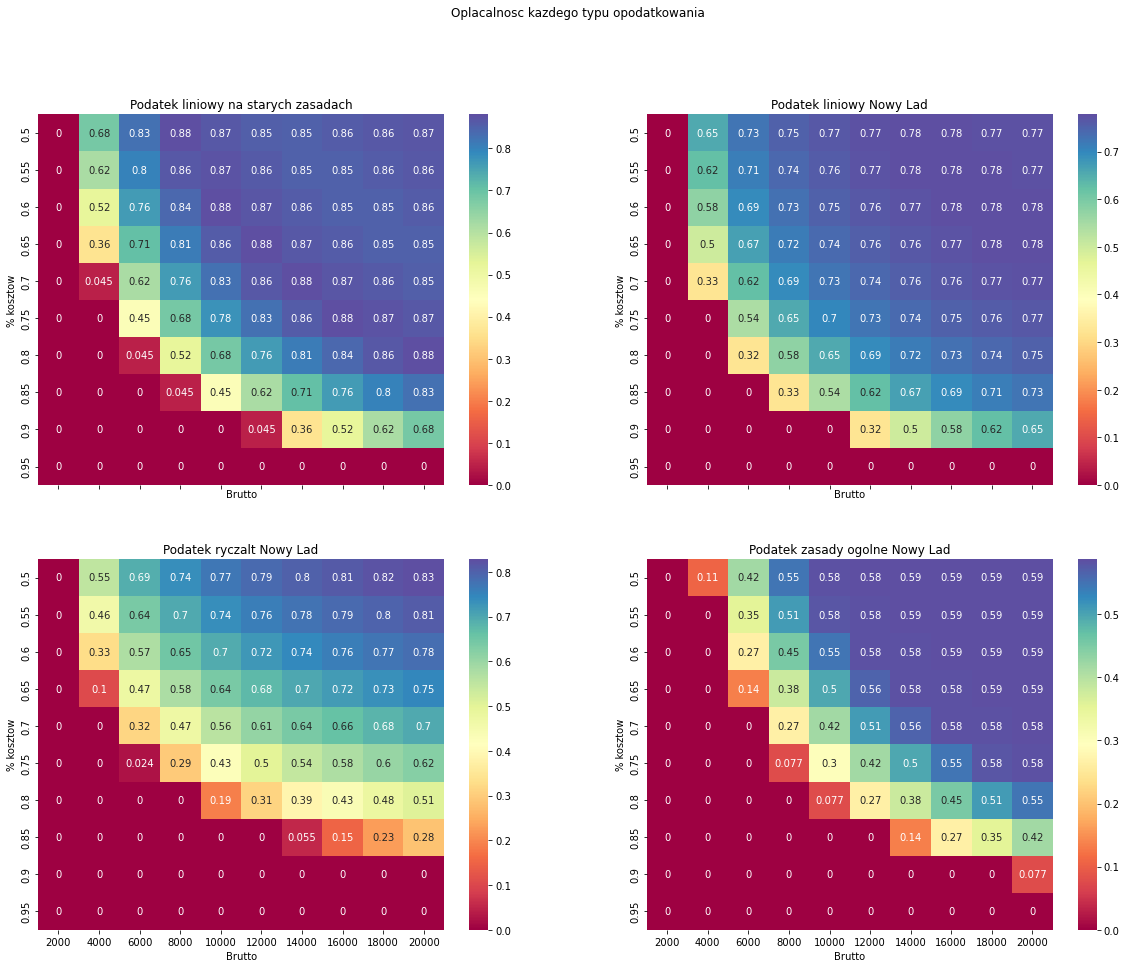

In [51]:
#Wykres opłacalności (ile dostajemy do ręki/ile zarobimy netto)
fig, axes = plt.subplots(2, 2, sharex=True,figsize=(20,15))
fig.suptitle('Oplacalnosc kazdego typu opodatkowania')


axes[0,0].set_title('Podatek liniowy na starych zasadach')
pivot_liniowySL= df.pivot('% kosztow','Brutto','% netto Liniowy SL')
sns.heatmap(pivot_liniowySL,cmap='Spectral',ax=axes[0,0],yticklabels=pivot_liniowySL.index.values.round(2),xticklabels=pivot_liniowySL.columns.values,annot=True)

axes[0,1].set_title('Podatek liniowy Nowy Lad')
pivot_liniowyNL= df.pivot('% kosztow','Brutto','% netto Liniowy NL')
sns.heatmap(pivot_liniowyNL,cmap='Spectral',ax=axes[0,1],yticklabels=pivot_liniowyNL.index.values.round(2),annot=True)

axes[1,0].set_title('Podatek ryczalt Nowy Lad')
pivot_ryczaltNL= df.pivot('% kosztow','Brutto','% netto Ryczalt NL')
sns.heatmap(pivot_ryczaltNL,cmap='Spectral',ax=axes[1,0],yticklabels=pivot_ryczaltNL.index.values.round(2),annot=True)

axes[1,1].set_title('Podatek zasady ogolne Nowy Lad')
pivot_progiNL= df.pivot('% kosztow','Brutto','% netto progi NL')
sns.heatmap(pivot_progiNL,cmap='Spectral',ax=axes[1,1],yticklabels=pivot_progiNL.index.values.round(2),annot=True)



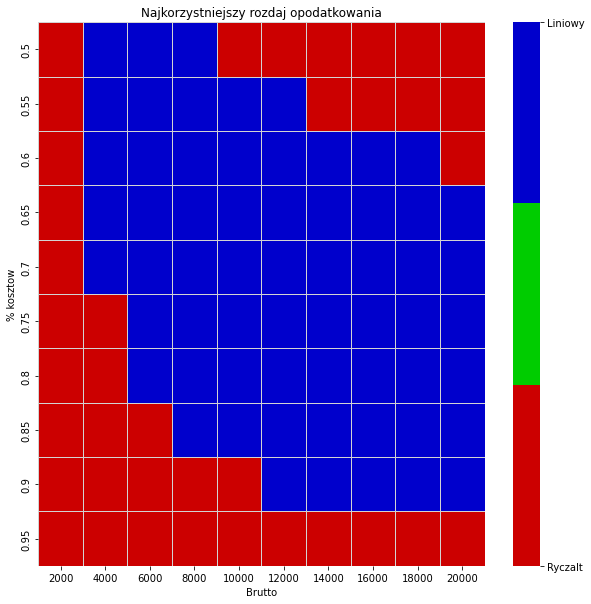

In [52]:
#Wybor najkorzystniejszego sposobu opodatkowania
df['Najkorzystniejszy']=df[['% netto Ryczalt NL','% netto Liniowy NL','% netto progi NL']].idxmax(axis=1).replace(['% netto Ryczalt NL','% netto Liniowy NL','% netto progi NL'],[0,1,2])

pivot_najlepszy= df.pivot('% kosztow','Brutto','Najkorzystniejszy')


plt.figure(figsize=(10,10))
#Generowanie mapy kolorów dla wartosci dyskretnych
myColors = ((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

ax = sns.heatmap(pivot_najlepszy,cmap=cmap,linewidths=.5, linecolor='lightgray')
ax.set_title('Najkorzystniejszy rozdaj opodatkowania')

#Legenda
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1, 2])
colorbar.set_ticklabels(['Ryczalt', 'Liniowy', 'Zasady Ogolne'])
# 0 = Ryczałt
# 1 = Liniowy
# 2 = Zasady Ogolne